In [1]:
import pandas as pd 
from abc import ABC, abstractmethod
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import networkx as nx
import cvxpy as cp
import seaborn as sns
from datetime import timedelta
from collections import Counter, defaultdict
import networkx as nx

# Build Class and function

In [71]:
class Portfolio:
    def __init__(self, data_csv, start="2000-01-01", end="2024-12-31", price_data=None):
        self.data_csv = data_csv
        self.symbols = self.data_csv['Symbol']
        self.sector = self.data_csv['Sector']
        self.start = start
        self.end = end
        self.price_data = price_data
        self.log_returns = None
        self.dates = None
        self.C_g = None
        self.D = None
        self.cov_g = None
        self.communities = None
        weight = None

    def get_data_yahoo(self, save = False, path = None, no_nan = True):
        self.price_data = yf.download(self.symbols.to_list(), self.start , self.end, auto_adjust=False)['Adj Close']
        if no_nan:
            self.price_data.dropna(axis=1, inplace = True)
        if save:
            if path is None:
                raise ValueError("Path must be specified if save is True.")
            self.price_data.to_csv(path)
    
    def compute_log_return(self):
        if self.price_data is None:
             raise ValueError("Price data not available, download or use a valid dataframe")
        self.price_data.dropna(axis = 1, inplace = True)
        self.log_returns = np.log(self.price_data / self.price_data.shift(1)).dropna()
        self.symbols =  self.log_returns.columns.to_list()
        self.dates = pd.to_datetime(self.log_returns.index)
        self.sector = self.data_csv[self.data_csv['Symbol'].isin(self.log_returns.columns)]['Sector'].to_list()
        return self.log_returns

    def _evaluate_cov_g(self):
        self.D = np.diag(self.log_returns.std().values)
        self.cov_g = self.D @ self.C_g @ self.D 
        return self.cov_g
    
    def mesoscopic_filter(self):
        if self.log_returns is None:
            raise ValueError("No log-return, please before compute log return")
        corr_matrix = self.log_returns.corr().values
        T, N = self.log_returns.shape
        eigvals, eigvecs = np.linalg.eigh(corr_matrix)
        Q = T / N 
        lambda_max = (1 + 1 / np.sqrt(Q))**2 
        lambda_1 = eigvals[-1] #isolate the biggest eigenvalue
        sigma2 = 1 - lambda_1 / N
        lambda_max = sigma2 * (1 + 1 / np.sqrt(Q))**2 #Laloux correction
        meso_indices = np.where((eigvals > lambda_max) & (eigvals < lambda_1))[0]
        C_g = np.zeros((N, N))
        for i in meso_indices:
            C_g += eigvals[i] * np.outer(eigvecs[:, i], eigvecs[:, i])
        self.C_g = C_g
        self._evaluate_cov_g()
        return self.C_g



    @staticmethod   
    def _get_risk_fractions(returns_window):
        T, N = returns_window.shape
        corr = returns_window.corr().values

        eigvals, _ = np.linalg.eigh(corr)
        eigvals = np.sort(eigvals)
        
        Q = T / N
        lambda_1 = eigvals[-1]
        sigma2 = 1 - lambda_1 / N
        lambda_max = sigma2 * (1 + 1 / np.sqrt(Q))**2

        noise = eigvals[eigvals <= lambda_max]
        market = np.array([lambda_1])
        meso = eigvals[(eigvals > lambda_max) & (eigvals < lambda_1)]

        total_risk = np.sum(eigvals)
        
        return {
            "noise": np.sum(noise) / total_risk,
            "market": np.sum(market) / total_risk,
            "meso": np.sum(meso) / total_risk,
        }

    def plot_stability(self, windows_years = 2):

        if self.dates is None:
            raise ValueError("No date available, please run compute_log_return first")
        windows = []
        start = self.dates[0]

        while start + pd.DateOffset(years = windows_years) < self.dates[-1]:
            end = start + pd.DateOffset(years = windows_years)
            windows.append((start, end))
            start = end
        risks = []

        for start, end in windows:
            returns = np.exp(self.log_returns) - 1
            returns.index = pd.to_datetime(returns.index)
            subset = returns[(returns.index >= start) & (returns.index < end)]
            risks.append(self._get_risk_fractions(subset))

        risk_df = pd.DataFrame(risks)
        risk_df['window_start'] = [w[0] for w in windows]
        risk_df.set_index('window_start', inplace=True)
        diffs = risk_df.diff().dropna()
        std_noise = diffs['noise'].std()
        std_market = diffs['market'].std()
        std_meso = diffs['meso'].std()

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(risk_df.index, risk_df['noise'], label='Noise', color = "red", marker = 'o', linestyle = 'dashed')
        ax.plot(risk_df.index, risk_df['market'], label='Systemic', color = "blue", marker = 'o', linestyle = 'dashed')
        ax.plot(risk_df.index, risk_df['meso'], label='Mesoscopic', color = "green", marker = 'o', linestyle = 'dashed')

        # Annotazioni delle deviazioni standard con simbolo sigma nel grafico
        ax.text(risk_df.index[3], risk_df['noise'].iloc[3], rf'$\sigma_r={std_noise:.3f}$', va='bottom', ha='left', size = 12,bbox=dict(facecolor='white', alpha=0.5))
        ax.text(risk_df.index[3], risk_df['market'].iloc[3], rf'$\sigma_s={std_market:.3f}$', va='bottom', ha='right', size = 12,bbox=dict(facecolor='white', alpha=0.5))
        ax.text(risk_df.index[3], risk_df['meso'].iloc[3], rf'$\sigma_g={std_meso:.3f}$', va='bottom', ha='left', size = 12,bbox=dict(facecolor='white', alpha=0.5))

        ax.set_title('Cumulative Risk Fractions over Time')
        ax.set_ylabel('Fraction of Total Risk')
        ax.set_xlabel('Start of 2-Year Window')
        ax.legend()
        ax.grid(True)
        fig.tight_layout()
        plt.show()

    def community_discover(self, algo = "Louvain", seed = 42, k = 5):
        if self.C_g is None:
            raise ValueError("No Mesoscopic structure found, please run mesoscopic_filter")

        G = nx.from_numpy_array(self.C_g)
        if algo == "Louvain":
            self.communities = nx.community.louvain_communities(G, seed=seed, weight='weight')
        elif algo == "Asyn":
            self.communities = list(nx.community.asyn_fluidc(G, k = k,seed = seed))
        else:
            raise ValueError("Select correct algorithm for community discover")
        return self.communities

    def plot_communities_pie(self):
        if self.communities is None:
            raise ValueError("No communities found, please run community_discover")
        comm2sectors = defaultdict(list)
        for comm_id, nodes in enumerate(self.communities):
            for node in nodes:
                comm2sectors[comm_id].append(self.sector[node])

        sector_labels = sorted(set(self.sector)) 
        colors = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
        ]
        sector_color_dict = dict(zip(sector_labels, colors))

        n_communities = len(comm2sectors)
        n_cols = min(n_communities, 3)
        n_rows = (n_communities + n_cols - 1) // n_cols

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
        axs = axs.flatten() if n_communities > 1 else [axs]

        for i, (comm_id, sectors) in enumerate(comm2sectors.items()):
            ax = axs[i]
            count = Counter(sectors)
            sizes = [count.get(s, 0) for s in sector_labels]
            total = sum(sizes)
            sizes = [s / total for s in sizes] if total > 0 else [0] * len(sizes)

            # Explode: separa le fette grandi per leggibilità
            explode = [0.05 if s > 0.15 else 0 for s in sizes]

            wedges, texts, autotexts = ax.pie(
                sizes,
                colors=[sector_color_dict[s] for s in sector_labels],
                startangle=90,
                wedgeprops=dict(edgecolor='white'),
                autopct=lambda p: f'{p:.1f}%' if p > 3 else '',
                pctdistance=0.8,
                labeldistance=1.1,
                explode=explode
            )

            for text in autotexts:
                text.set_fontsize(12)
                text.set_horizontalalignment('center')
                text.set_verticalalignment('center')
                text.set_weight('bold')

            ax.set_title(f"Community {comm_id + 1}", fontsize=14)
            ax.axis('equal')

        # Rimuovi subplot extra se < n_rows * n_cols
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')

        # Legenda globale
        fig.legend(
            handles=[plt.Line2D([0], [0], marker='o', color='w', label=lab,
                                markerfacecolor=sector_color_dict[lab], markersize=10)
                    for lab in sector_labels],
            loc='lower center',
            ncol=min(len(sector_labels), 5),
            bbox_to_anchor=(0.5, -0.05)
        )

        plt.tight_layout()
        plt.show()

    @staticmethod
    def solve_gmv(cov_g, short = False):
        N = cov_g.shape[0]
        w = cp.Variable(N)
        objective = cp.Minimize(cp.quad_form(w, cov_g))
        if short:
            constraints = [cp.sum(w) == 1]
        else:
            constraints = [cp.sum(w) == 1,  w >= 0 ]
        problem = cp.Problem(objective, constraints)
        problem.solve()
        return w.value

    @staticmethod
    def solve_gmv_coomunity(cov_g, communities, short = False):
        n = len(communities)
        N = cov_g.shape[0]

        Sigma_c = np.zeros((n, n))
        
        for c in range(n):
            assets_c = communities[c]
            Nc = len(assets_c)

            var_c = np.mean([cov_g[i, i] for i in assets_c])
            cov_c = np.mean([cov_g[i, j] for i in assets_c for j in assets_c if i != j]) if Nc > 1 else 0
            Sigma_c[c, c] = (var_c + (Nc - 1) * cov_c)

            for k in range(c + 1, n):
                assets_k = communities[k]
                cross_cov = np.mean([cov_g[i, j] for i in assets_c for j in assets_k])
                Sigma_c[c, k] = Sigma_c[k, c] = cross_cov

        W = cp.Variable(n)
        objective = cp.Minimize(cp.quad_form(W, Sigma_c))
        if short:
            constraints = [cp.sum(W) == 1]
        else:
            constraints = [cp.sum(W) == 1, W >= 0]
        
        prob = cp.Problem(objective, constraints)
        prob.solve()

        weights = np.zeros(N)
        for c, Wc in enumerate(W.value):
            Nc = len(communities[c])
            for i in communities[c]:
                weights[i] = Wc / Nc

        return weights

## Collect and Download Data

In [3]:
data_csv = pd.read_csv('data/SandP500.csv')
data_csv.sort_values(by='Symbol', inplace = True)

### Download (If you already have dataset, you can skip it)

In [4]:
portfolio = Portfolio(data_csv)
portfolio.get_data_yahoo(save = True, path = "data\\price_data.csv", no_nan = True)

[**                     5%                       ]  23 of 496 completedHTTP Error 404: 
[*********************100%***********************]  496 of 496 completed

101 Failed downloads:
['BRCM', 'HSP', 'GGP', 'TWC', 'MJN', 'SNI', 'BCR', 'ZMH', 'STJ', 'SWY', 'WAG', 'DPS', 'MWV', 'GMCR', 'CBG', 'RAI', 'POM', 'CAM', 'FDO', 'COG', 'HCN', 'COH', 'SIAL', 'WYN', 'CFN', 'NLSN', 'LUK', 'MNK', 'LO', 'SPLS', 'KRFT', 'WFM', 'HCBK', 'PCLN', 'ARG', 'LLTC', 'WLP', 'CVC', 'MHFI', 'KORS', 'TSO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2000-01-01 -> 2024-12-31)')
['VAR', 'DLPH', 'ETFC', 'ALTR', 'XLNX', 'DFS', 'BBT', 'BBBY', 'CTXS', 'PBCT', 'LM', 'ABC', 'AVP', 'TSS', 'JEC', 'XL', 'XEC', 'TMK', 'MON', 'PDCO', 'AGN', 'ALXN', 'CELG', 'DNR', 'HCP', 'APC', 'PXD', 'QEP', 'CERN', 'SWN', 'ADS', 'KSU', 'GPS', 'CTL', 'PKI', 'YHOO', 'MRO', 'DO', 'NBL', 'RHT', 'SYMC', 'VIAB', 'FTR', 'RTN', 'CHK', 'WIN', 'DISCA', 'ESV', 'CBS', 'MYL', 'DTV', 'UTX', 'LLL', 'FLIR', 'HRS', 'BLL', 'TIF', 'FISV']: 

### Prepare the Dataset

In [72]:
price_data =  pd.read_csv('data/price_data.csv', index_col=0)
portfolio = Portfolio(data_csv, price_data = price_data)
portfolio.compute_log_return()

,A,AA,AAPL,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WM,WMB,WMT,WY,XEL,XOM,XRAY,XRX,YUM,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.079464,0.004623,-0.088078,-0.028987,-0.087618,-0.051913,-0.010471,0.000000,-0.049914,0.000000,...,-0.003604,-0.022427,-0.038137,-0.038291,0.022765,-0.019340,0.000000,-0.047628,-0.020305,-0.049635
2000-01-05,-0.064037,0.056047,0.014527,-0.001840,0.019578,0.014492,-0.015915,-0.009662,-0.065064,0.037956,...,0.003604,0.060018,-0.020619,0.051619,0.037859,0.053082,0.017139,0.050209,0.005114,-0.001184
2000-01-06,-0.038820,-0.013168,-0.090514,0.034393,0.008130,-0.027718,0.005333,0.013261,-0.062859,-0.003732,...,-0.007220,0.021134,0.010853,0.045717,-0.009331,0.050406,0.001307,-0.020834,-0.008539,0.014117
2000-01-07,0.080042,-0.002949,0.046281,0.010620,0.047440,0.027718,0.015832,0.022500,0.112049,0.014842,...,-0.040671,0.026268,0.072845,-0.033437,0.000000,-0.002939,-0.002614,0.023409,-0.022551,0.002334
2000-01-10,0.058813,-0.002959,-0.017744,-0.007068,0.037883,0.083468,0.000000,0.024292,-0.010151,-0.007394,...,0.003766,-0.018692,-0.018417,-0.004369,0.000000,-0.014080,0.023287,-0.023409,0.039558,-0.018230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.000669,0.019367,0.003060,0.000700,-0.000962,0.014578,-0.001586,0.000442,-0.002115,0.004470,...,-0.009911,0.010415,-0.020703,0.020872,0.004736,0.004053,0.013280,0.118974,0.011269,0.013142
2024-12-24,0.011083,0.000777,0.011413,0.003929,0.002683,0.014782,0.004355,0.007822,0.012494,0.013291,...,0.007723,0.010124,0.025462,0.006390,0.007210,0.000940,-0.002642,-0.023556,0.008480,0.010791
2024-12-26,-0.001986,-0.006757,0.003171,0.004434,0.004944,-0.000138,-0.000395,0.002594,-0.003159,-0.002203,...,-0.001754,-0.011791,0.001186,-0.003190,-0.000440,0.000845,0.013663,-0.006522,0.007380,0.006889


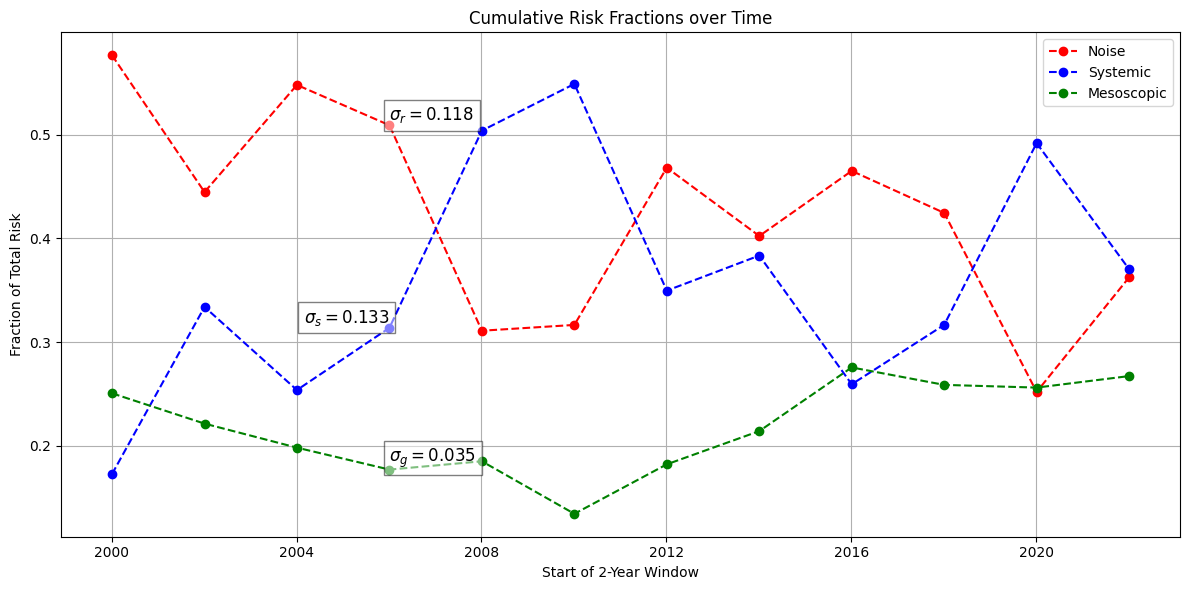

In [73]:
portfolio.plot_stability()

## Community

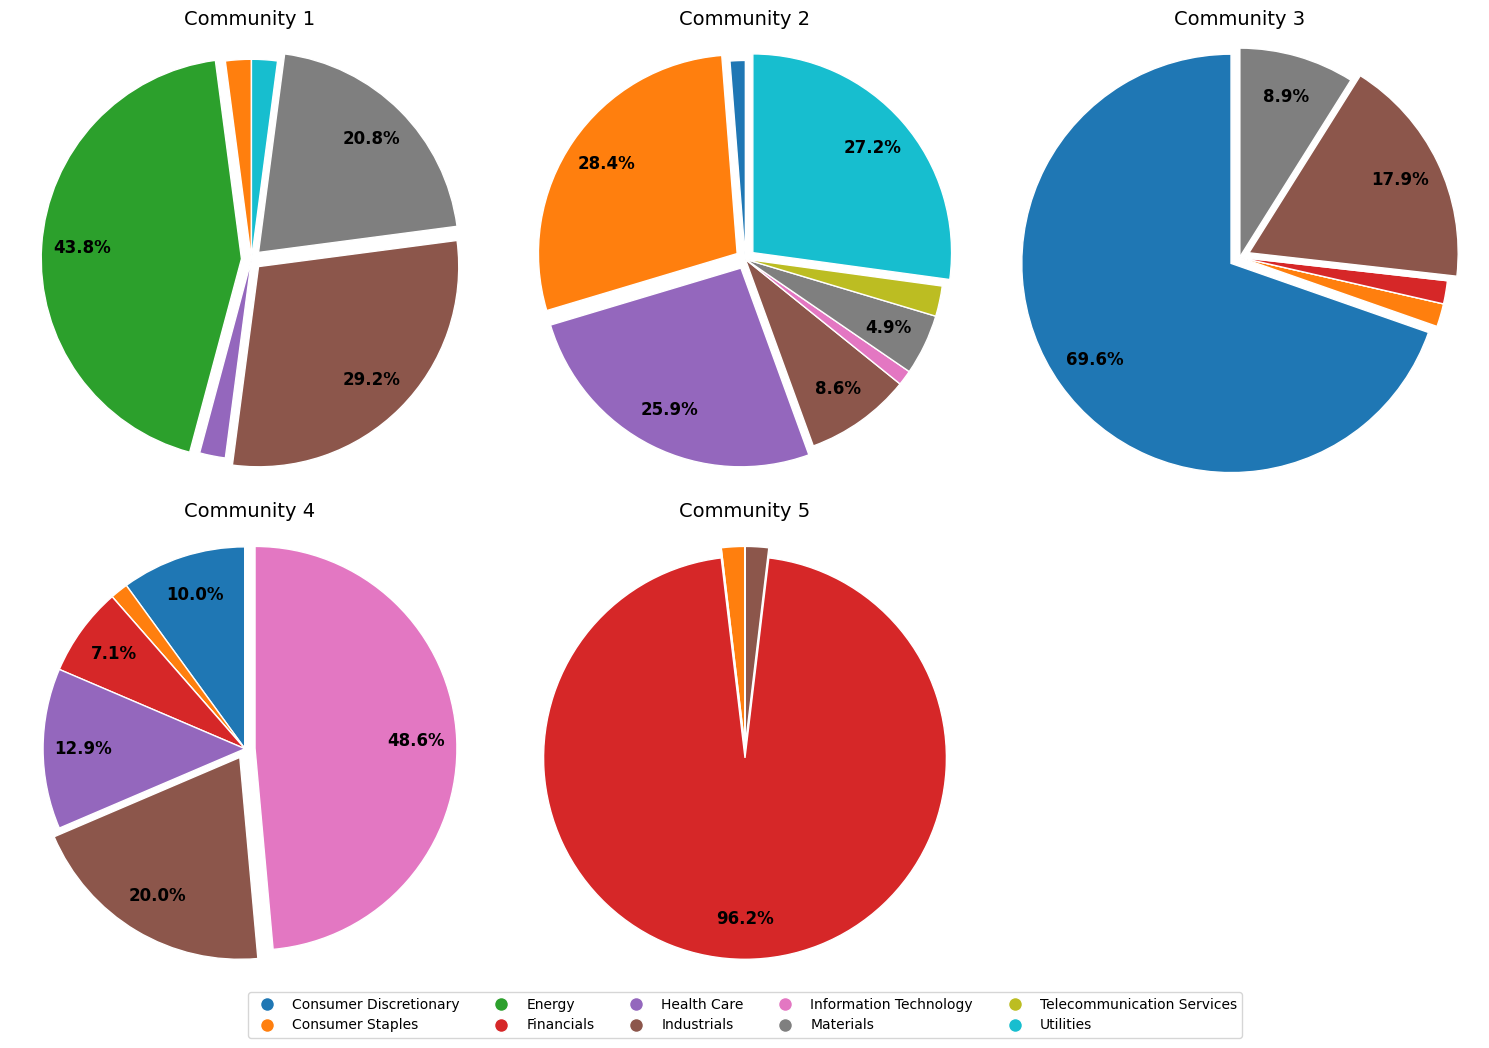

In [74]:
portfolio.mesoscopic_filter()
portfolio.community_discover(algo = "Louvain", k = 5)
portfolio.plot_communities_pie()

In [75]:
w_meso = portfolio.solve_gmv(portfolio.cov_g)
w_comm = portfolio.solve_gmv_coomunity(portfolio.cov_g, portfolio.communities)

In [ ]:
def community_based_portfolio(C_g, communities):
    n = len(communities)  # numero di comunità
    N = C_g.shape[0]

    Sigma_c = np.zeros((n, n))
    
    for c in range(n):
        assets_c = communities[c]
        Nc = len(assets_c)

        var_c = np.mean([C_g[i, i] for i in assets_c])
        cov_c = np.mean([C_g[i, j] for i in assets_c for j in assets_c if i != j]) if Nc > 1 else 0
        Sigma_c[c, c] = (var_c + (Nc - 1) * cov_c)

        for k in range(c + 1, n):
            assets_k = communities[k]
            cross_cov = np.mean([C_g[i, j] for i in assets_c for j in assets_k])
            Sigma_c[c, k] = Sigma_c[k, c] = cross_cov

    W = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(W, Sigma_c))
    constraints = [cp.sum(W) == 1, W >= 0]
    prob = cp.Problem(objective, constraints)
    prob.solve()

    weights = np.zeros(N)
    for c, Wc in enumerate(W.value):
        Nc = len(communities[c])
        for i in communities[c]:
            weights[i] = Wc / Nc

    return weights

In [411]:
cov_matrix = np.diag(portfolio.log_returns.std().values) @ C_g @ np.diag(portfolio.log_returns.std().values)
w_test = community_based_portfolio(portfolio.C_g, portfolio.communities)

## Portfolio Building

## First: Simple Mesoscopic

In [144]:
def solve_gmv_cvxpy(C_g,D):
    Sigma_g = D @ C_g @ D
    N = Sigma_g.shape[0]
    w = cp.Variable(N)
    objective = cp.Minimize(cp.quad_form(w, Sigma_g))
    constraints = [cp.sum(w) == 1,  w >= 0 ]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value

In [ ]:
def solve_community_gmv_cvxpy(C_g, communities):
    N = C_g.shape[0]
    w = cp.Variable(N)
    constraints = [cp.sum(w) == 1,  w >= 0 ] 

    for community in communities.values():
        for i in range(1, len(community)):
            constraints.append(w[community[i]] == w[community[0]])

    objective = cp.Minimize(cp.quad_form(w, C_g))
    problem = cp.Problem(objective, constraints)
    problem.solve()

In [146]:
D = np.diag(log_ret.std().values)
w_g = solve_gmv_cvxpy(C_g, D)
w_normal = solve_gmv_cvxpy(log_ret.corr().values, D)
w_N = np.ones(len(w_g)) / len(w_g)

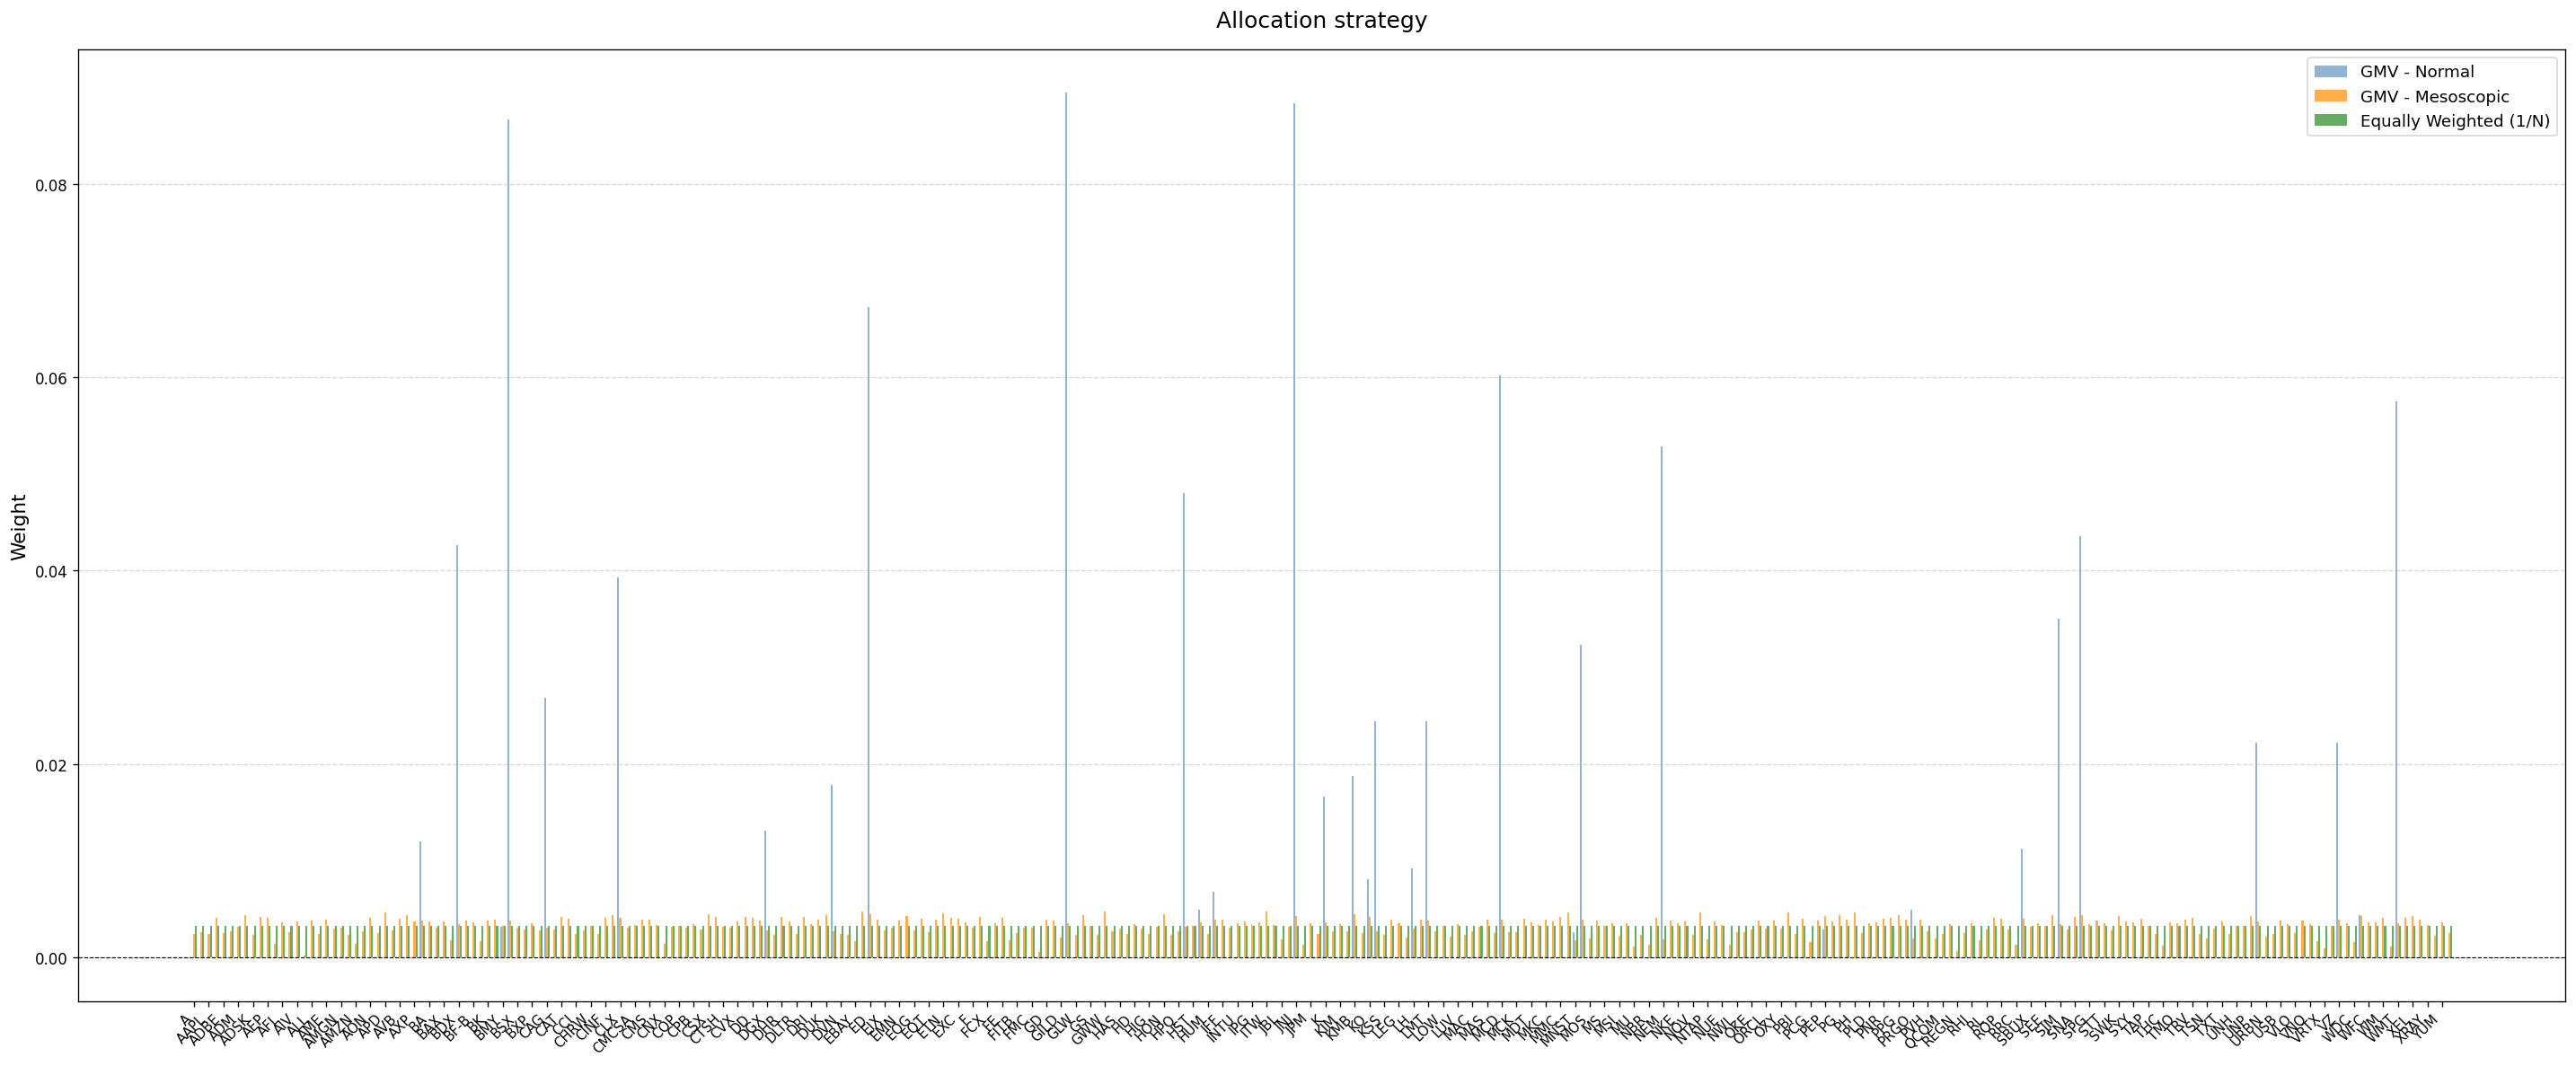

In [154]:
x = np.arange(len(true_tick)) 
width = 0.25

plt.figure(figsize=(24, 10), dpi=120)

plt.bar(x - width, w_normal, width, label='GMV - Normal', color='steelblue', alpha=0.6)
plt.bar(x, w_g, width, label='GMV - Mesoscopic', color='darkorange', alpha=0.7)
plt.bar(x + width, w_N, width, label='Equally Weighted (1/N)', color='forestgreen', alpha=0.7)

plt.axhline(0, color='black', linewidth=0.7, linestyle='--')

# Mostra etichette ogni 5 titoli (modificabile)
step = 2
plt.xticks(x[::step], [true_tick[i] for i in x[::step]], rotation=45, ha='right', fontsize=9)

plt.ylabel('Weight', fontsize=13)
plt.title('Allocation strategy', fontsize=15, pad=15)

plt.legend(fontsize=11, loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Try backtest

In [400]:
def backtest_portfolios(df, risk_free_rate = 0 ):
    T = len(df)
    df_train = df.iloc[:T//2]
    df_test = df.iloc[T//2:]
    mu_train = df_train.mean().values
    sigma_train = df_train.std().values
    D = np.diag(sigma_train)
    C_normal = df_train.corr().values
    C_g = mesoscopic_filter(df_train)
    N = df.shape[1]
    w_equal = np.ones(N) / N
    w_gmv_normal = solve_gmv_cvxpy(C_normal, D)
    w_gmv_meso = community_based_portfolio(C_g, portfolio.communities)
    weights = {
            "Equal": w_equal,
            "GMV-Normal": w_gmv_normal,
            "GMV-Mesoscopic": w_gmv_meso
        }
    def portfolio_stats(w, df, sigma_pred):
            returns = df @ w
            mu_ann = returns.mean() * 252
            sigma_real = returns.std(ddof=1) * np.sqrt(252)
            sharpe = (mu_ann - risk_free_rate) / sigma_real
            reliability = abs(sigma_real - sigma_pred) / sigma_pred
            cumulative = (1 + returns).cumprod()
            return {
                "sharpe": sharpe,
                "sigma_real": sigma_real,
                "reliability": reliability,
                "cumulative": cumulative
            }

    # -----------------------
    # 5. Calcola performance
    # -----------------------
    results = {"Train": {}, "Test": {}}
    for name, w in weights.items():
        sigma_pred = np.sqrt(w.T @ (D @ C_normal @ D) @ w)
        results["Train"][name] = portfolio_stats(w, df_train, sigma_pred)
        results["Test"][name] = portfolio_stats(w, df_test, sigma_pred)

    # -----------------------
    # 6. Plot rendimenti cumulativi (Test)
    # -----------------------
    plt.figure(figsize=(14, 6))
    for name in weights:
        plt.plot(results["Test"][name]["cumulative"].values, label=name)
    plt.title("Rendimenti cumulativi - Periodo di Test")
    plt.ylabel("Crescita del capitale")
    plt.xlabel("Giorni")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # -----------------------
    # 7. Tabella riepilogo
    # -----------------------
    summary = []
    for periodo in ["Train", "Test"]:
        for name in weights:
            s = results[periodo][name]
            summary.append({
                "Periodo": periodo,
                "Portafoglio": name,
                "Sharpe Ratio": round(s["sharpe"], 3),
                "σ_realizzato": round(s["sigma_real"], 3),
                "Reliability": round(s["reliability"], 3)
            })

    df_summary = pd.DataFrame(summary)
    return df_summary